In [1]:
# import statements for rest of notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['figure.figsize'] = 8,8
import math as m   # importing math library outside function definition saves time 
import numpy as np
from IPython.display import Image
import scipy as sci
from scipy.misc import derivative
import scipy.optimize as opt
import sympy as sym
from numpy import pi
from itertools import chain, repeat


# Using Jupyter Notebooks to perform optical ray tracing
### Things to know about this notebook:
The goal of this notebook is to provide a toolbox that students or teachers could use to explore or demonstrate concepts in geometrical optics such as spherical abberation, chromatic abberation, and even the effects transmittance, reflectancs, and polarization effects. Ray tracing is the method of choice to achieve these objectives, and we have built in the ability to easily select some standard lens shapes, as well as to define your own custom lenses. The simulator is written such that it can be extended and tinkered with as the user sees fit. 

We have taken an object oriented approach to programming this simulator as it provides clarity into how the various parts interact. Throughout the notebook we will comment and annotate code to explain the more complicated segments and illustrate how all the pieces come together. 

### Useful uncategorized information  

1. Coordinate System:
    Currently the lenses are restricted to the first quandrant of the XY plane. Most examples are set up with the intended 
    direction of propagation in the +y direction. If we refer to things being below or above others, that is to say that the y
    coordinate of the below item is less than the above object. 

2. Lenses:
    Lenses are represented as a list[] of ordered pairs (domain, surfaces). Each ordered pair contains
    a domain list and a surface list. The domain list defines a piecewise definition of the segment of the lens. 
    If multiple surfaces are present over one domain, they are given in no particular order. For clarity imagine the following:
             -------f(x)-------
    from x0  -------g(x)------- to x1 would be translated as [[x0,x1],[g,f]] where this is one element of the lens
    
    The lens (domain, surfaces) elements are ordered by the domain component. The domain for a given lens must be continuous. 
    Hence if we have the element [[x0,x1],[f1,g1]] then the next element should be [[x1,x2],[f2,g2]] where x2 > x1 and the 
    fi, gi's are surfaces defined over the given domains. 
    
    Vertical lines require special attention. Many other curves in the xy plane may be represented as functions of x 
    but vertical lines cannot be. Hence we elected to give vertical lines a domain of x = c and the 
    surfaces are the y points that define the vertical line segment. This translates to the following:
    
    y1
    |
    |
    |
    |
    |
    |
    |
    |
    y0 at x = x0 -> [[x0],[y0,y1]]
    
    The lens class has predefined lenses in it along with the capability to do gaussian optics as specified by the user.
    
3. Rays:
    Rays carry a lot of information in them. They are defined as a geometrical ray. With a source location and an angle measured
    counter-clockwise from the horizonal (in radians). 
    
4. RayGenerator:
    This makes the initial list of rays that will propagate through the system. It can create point sources, (parallel) beam 
    sources, and converging (beam) sources. 
    
5. Driver:
    This class binds all of the constitutent parts together. It is responsible for handling ray propagation, ray reflection/
    refraction, and plotting the results.

 

Our approach:

    Surface Finding:
        Each ray is modeled as a function of x (unless it's vertical) and each part of the lens is also. Hence we can use a
        numerical root solver in the scipy optimize library to determine where the ray will cross the surface, if ever. We can 
        repeat this for every surface avaliable and take the surface which minimizes the distance from our orginial point as
        this minimizes the optical path length and would therefore be the one the ray would actually follow. 
        
        This code will not work for media whose index of refraction is position dependent.
        
    Refracting:
        We employ snell's law as our method of refracting rays. To determine the normal vector we leverage the functional form 
        of our surfaces and calculate the normal vector based on differential calculus. Once we have that, we use the dot 
        product to calculate the angle of incidence and snell's law for the angle of transmission. Finally, to avoid the
        complications induced from having several coordinate systems, we calculate the xy components of the refracted/reflected
        ray by using the 2D rotation matrix for a vector. 


In [2]:
'''
The ray class is esentially a container for a lot of attributes associated with a light ray

We have broken down which category each property best fits into
this typically will indicate which part of the program will use the field although
there may be overlap with other categories.

Summary of fields:
The light ray is defined in a mathematical sense as a normal ray which has an end point (source location) and an
angle that provides the ray direction (denoted angle) measured CCW from the horizontal. 

Due to our method of determining where a ray will strike a surface. 
''' 

class Ray:
    rayCount = 0
    def __init__(self, x, y, angle, wavelength=0,identity=42, intensity=1):
        
        #vector quantities
        self.sourceLocation = (x,y)
        self.angle = angle
        self.unitVector = [np.cos(angle), np.sin(angle)]
        
        #line quantities
        self.slope = (self.unitVector[1]/self.unitVector[0])
        self.yIntercept = y - x*self.slope # y = mx + b --> b = y - mx
        self.xIntercept = - self.yIntercept/self.slope # x = -b/m
        
        #plot quantities
        self.locationHistory = [self.sourceLocation] # keep track of the prevous interface points
        self.angleHistory = [angle*180/np.pi]
        self.slopeFromRight = 0
        if(self.slope < 0):
            self.slopeFromRight = 1
        
        #light quantities
        self.wavelength = wavelength
        self.intensity = intensity
        self.intensityList = [intensity]
        self.parallel = 0.5
        self.perpendicular = 0.5
        
        #program quantities
        self.objIndex = -1
        #self.identity = identity #this can be set up in the ray generator
        self.identity = Ray.rayCount
        Ray.rayCount+=1
        self.reflected = 0
        self.normalVectorHistory = []
        
    def update_location_history(self, x, y, angle, objIndex):
        
        #update vector quantities:
        self.sourceLocation = (x,y)
        self.angle = angle
        self.unitVector = [np.cos(angle),np.sin(angle)]
        
        #update line quantities
        self.slope = (self.unitVector[1] / self.unitVector[0])
        self.yIntercept = y - x*self.slope # y = mx + b --> b = y - mx
        self.xIntercept = - self.yIntercept/self.slope # x = -b/m
        
        #update plot quantities
        self.locationHistory.append((x,y))
        self.angleHistory.append(angle*180/np.pi)
        
        #update program quantity
        self.objIndex = objIndex
        
        
    def rPerp(angleI, angleT):
        return -np.sin(angleI-angleT)/np.sin(angleI+angleT)
    def rPara(angleI, angleT):
        return np.tan(angleI-angleT)/np.tan(angleI+angleT)
    def tPerp(angleI, angleT):
        return 2*np.sin(angleT)*np.cos(angleI)/np.sin(angleI+angleT)
    def tPara(angleI,angleT):
        return 2*np.sin(angleT)*np.cos(angleI)/(np.sin(angleI+angleT)*np.cos(angleI-angleT))
    
    #should be irradience
    def update_intensity_history(self, angleI, angleT, nI, nT):
        R = self.parallel*Ray.rPara(angleI,angleT)**2 + self.perpendicular*Ray.rPerp(angleI,angleT)**2
        T = (nT(self.wavelength)*np.cos(angleT)/(nI(self.wavelength)*np.cos(angleI)))*(self.parallel*Ray.tPara(angleI,angleT)**2 + self.perpendicular*Ray.tPerp(angleI,angleT)**2)
        if(angleI == angleT):
            self.intensity*=R
            self.intensityList.append(self.intensity)
        else:
            self.intensity*=T
            self.intensityList.append(self.intensity)
        
    def printString(self):
        return "{0}\n{1}\n{2}\n".format(self.slope, self.xIntercept,np.asarray(self.angleHistory)*180/np.pi)

In [3]:
class RayGenerator:
    def __init__(self, rayList):
        
        self.theRayList = rayList
        
    @classmethod
    def point_source(cls, x0, y0, numberOfRays, startAngle, stopAngle, startLambda=1, endLambda=1):
        if startAngle == 0 and stopAngle == 2*np.pi:
            theAngleList = np.linspace(startAngle, stopAngle, numberOfRays+1)
        else:
            theAngleList = np.linspace(startAngle, stopAngle, numberOfRays)
        rayList = []
        for i, angle in enumerate(theAngleList):#still have to put in the color code
            rayList.append(Ray(x0,y0,angle, 0))
        return cls(rayList)
    
    @classmethod
    def beam_source(cls, x0, y0, x1, y1, numberOfRays, startLambda=1, endLambda=1):
        if x1 - x0 == 0 and y1 - y0 == 0 :
            raise(Exception("beam width must be non-zero"))
        rayAngle = np.arctan2((x1-x0),-(y1-y0))
        xList, yList = np.linspace(x0, x1, numberOfRays), np.linspace(y0, y1, numberOfRays)
        pointList = list(zip(xList, yList))
        rayList = []
        for i, point in enumerate(pointList):
            rayList.append(Ray(point[0],point[1],rayAngle,0,identity=i))
        return cls(rayList)
    
    @classmethod
    def converging_source(cls, x0, y0, x1, y1, numberOfRays, startAngle, stopAngle, startLambda=1, endLambda=1):
        if x1-x0 == 0 and y1-y0 == 0:
            raise(Exception("converging beam width must be non-zero"))
        xList, yList = np.linspace(x0, x1, numberOfRays), np.linspace(y0, y1, numberOfRays)
        pointList = list(zip(xList, yList))
        theAngleList = np.linspace(startAngle, stopAngle, numberOfRays)
        rayList = []
        for i, point in enumerate(pointList):
            rayList.append(Ray(point[0], point[1], theAngleList[i], 0))
        return cls(rayList)
        

In [4]:
#change the vertical line handling so that the second list are the value of the bounding functions
#this amounts to a scaffolding in which each case though be tested in case errors were made

#add more details as to what all of this is such as what r1 r2 etc are
#also change the parameter names of height and width to diameter and thickness repectively

########### comence commenting extravaganza ################# delayed, doubly delayed





class lens:
    def __init__(self,surfaceList=[],n=lambda x : 1.5):
        
        self.refractiveIndex = n
        self.surfaceList = surfaceList

    @classmethod
    def predefined(cls, name, nFunction=lambda x : 1.5, xOffSet=0, yOffSet=0):#I should probably include the r1, r2, height, and width values in these examples
        '''
        Here is a series of predefined surfaces that could be used as examples of the behavior of each lens type
        They also provide concrete models of what is generalized in the gaussian optics section below so that 
        someone wishing to use the code could troubleshoot via mimicing the structure shown below
        '''
        if(name == "biconvex"):
            f1 = lambda x : -(-(x-5-xOffSet)**2 + 9)**(1/2) + 5 + yOffSet
            f2 = lambda x : (-(x-5-xOffSet)**2 + 9)**(1/2) + 1 +yOffSet
            x0 = opt.fsolve(lambda x: f1(x)-f2(x), 2+xOffSet, xtol=1e-10, maxfev=200)
            x1 = opt.fsolve(lambda x: f1(x)-f2(x), 7+xOffSet, xtol=1e-10, maxfev=200)
            return cls(surfaceList = [[[x0[0],x1[0]],[f1,f2]]],n=nFunction)

        elif(name == "biconcave"):
            mySurfaceList = []
            f1 = lambda x : (-(x-5-xOffSet)**2 + 9)**(1/2) + 1 +yOffSet
            f2 = lambda x : -(-(x-5-xOffSet)**2 + 9)**(1/2) + 8 + yOffSet
            
            mySurfaceList.append([[3+xOffSet],[f1(3+xOffSet),f2(3+xOffSet)]])
            mySurfaceList.append([[3+xOffSet,7+xOffSet],[f1,f2]])
            mySurfaceList.append([[7+xOffSet],[f1(7+xOffSet),f2(7+xOffSet)]])
            return cls(surfaceList=mySurfaceList,n=nFunction)  

        elif(name == "planar convex"):
            f1 = lambda x : -(-(x-5-xOffSet)**2 + 9)**(1/2) + 5 + yOffSet
            f2 = lambda x : 3 + yOffSet
            x0 = opt.fsolve(lambda x: f1(x)-f2(x), 2+xOffSet, xtol=1e-10, maxfev=200)
            x1 = opt.fsolve(lambda x: f1(x)-f2(x), 7+xOffSet, xtol=1e-10, maxfev=200)
            return cls(surfaceList = [[[x0[0],x1[0]],[f1,f2]]],n=nFunction)

        elif(name == "planar concave"):
            mySurfaceList = []
            f1 = lambda x : (-(x-5-xOffSet)**2 + 9)**(1/2) + 1 +yOffSet
            f2 = lambda x : 6 + yOffSet
            mySurfaceList.append([[3+xOffSet],[f1(3+xOffSet),f2(3+xOffSet)]])
            mySurfaceList.append([[3+xOffSet,7+xOffSet],[f1,f2]])
            mySurfaceList.append([[7+xOffSet],[f1(7+xOffSet),f2(7+xOffSet)]])
            return cls(surfaceList=mySurfaceList, n=nFunction)

        elif(name == "meniscus convex"):
            f1 = lambda x: -(-(x-5-xOffSet)**2 + 16)**(1/2) + 6+yOffSet
            f2 = lambda x : -(-(x-5-xOffSet)**2 + 36)**(1/2) + 9+yOffSet
            x0 = opt.fsolve(lambda x: f1(x)-f2(x), 2+xOffSet, xtol=1e-10, maxfev=200)
            x1 = opt.fsolve(lambda x: f1(x)-f2(x), 8+xOffSet, xtol=1e-10, maxfev=200)
            return cls(surfaceList = [[[x0[0],x1[0]],[f1,f2]]],n=nFunction)

        elif(name == "meniscus concave"):#I could save using the append opperation and memory initialization by just expliciting spelling out what I wanted my list to be
            mySurfaceList = []
            f1 = lambda x : -(-(x-5-xOffSet)**2 + 9)**(1/2) + 4.5+ yOffSet
            f2 = lambda x : -(-(x-5-xOffSet)**2 + 49)**(1/2) + 8 + yOffSet
            mySurfaceList.append([[3+xOffSet],[f1(3+xOffSet),f2(3 + xOffSet)]])
            mySurfaceList.append([[3+xOffSet,7+xOffSet],[f1,f2]])
            mySurfaceList.append([[7+xOffSet],[f1(7+xOffSet),f2(7 + xOffSet)]])
            return cls(surfaceList = mySurfaceList,n=nFunction)
        else:
            raise(Exception("Unknown lens type, please enter one of the following:\nbiconvex, biconcave, planar convex, planar concave, meniscus convex, meniscus concave"))
    
    
    #put in a max option so that we can easily get the lens as wide as possible for a given set of radii
    #also we need the meniscus convex and concave cases for negative radii
    # work on expanding the convex cases so that they can handle lens with thickness greater than what then surfaces intersecting would normally allow
    @classmethod
    def gaussianOptics(cls,r1=0,r2=0,thickness=0,diameter=0,xOffSet=0,yOffSet=0,nFunction=lambda x:1.5):
        '''
        The basic stucture of this function is to deal with the various gaussian optics inputs we could recieve and handle them appropriately
        After some error handling most cases take on the following characteristic structure:
        
        if not explicit, applies to both
        
        * for concave: ensure enough information is provided
        * determine rmax for plotting and doing math later
        * define the two surface functions
        * for convex: determine where the surfaces intersect
        * use the helper method to concisely construct our surface data 
    
        '''
        
        def abrvFunc(r1,r2,f1,f2,diameter,x0=0,x1=0,xOffSet=0, thickness=0): #this is a helper function to make the code more readable(or less eye watering if you prefer)
            rmax = max(r1,r2)
            if(x0 != 0 or x1 != 0):
                if(abs(x1[0]-x0[0]) <= diameter):#we can either raise an exception or just use the maximal diameter
                    raise(Exception("this diameter exceeds the limitations imposed by the specified diameter"))
            xmin = rmax - diameter/2
            xmax = rmax + diameter/2
            mySurfaceList = [[[xmin+xOffSet],sorted([f1(xmin+xOffSet),f2(xmax+xOffSet)])]]
            mySurfaceList.append([[xmin+xOffSet,xmax+xOffSet],[f1,f2]])
            mySurfaceList.append([[xmax+xOffSet],sorted([f1(xmax+xOffSet),f2(xmax+xOffSet)])])
            return mySurfaceList
        
        def widthHandler(f1, f2, x0, x1, surfaceList):
            f1y0, f1y1, f2y0, f2y1 = f1(x0), f1(x1), f2(x0), f2(x1)
            if(f1y0 < f2y0 - 0.001 or f1y0 > f2y0 + 0.001):
                surfaceList.insert(0,[[x0],sorted([f1y0, f2y0])])
            if(f1y1 < f2y1 - 0.001 or f1y1 > f2y1 + 0.001):
                surfaceList.append([[x1],sorted([f1y1, f2y1])])
        
        if(((r1 or r2 or diameter) and thickness) or ((r1 or r2) and diameter) or (r1 and r2)):#this should say that at least two of the following(r1,r2,width,height) 
            #have to be given 
            
            if(thickness < 0 or diameter < 0): #deal with negative width
                raise(Exception("width and height are constrained to be greater than or equal to zero"))
            
            elif(thickness == 0 and diameter == 0 ):
                raise(Exception("at minimum a width or height must be specified for a lens along with r1 or r2"))
            
            elif(r1 > 0 and r2 > 0 and r1 < r2):#meniscus convex case 1 #fixed
                if(not thickness):
                    thickness = abs(r1-(r1**2 - diameter**2/4)**(1/2) - r2 + (r2**2-diameter**2/4)**(1/2))
                rmax = r2
                f1 = lambda x : -(-(x-rmax-xOffSet)**2 + r1**2)**(1/2) + rmax+1 +yOffSet -r2 + r1 - thickness
                f2 = lambda x : -(-(x-rmax-xOffSet)**2 + r2**2)**(1/2) + rmax+1 +yOffSet
                d = -r1 + r2 + thickness
                if(d < 0):
                    d = -d
                elif(d == 0):
                    d = 0.001
                a = (1/d)*(4*d**2*r1**2 - (d**2 - r2**2 + r1**2)**2)**(1/2)
                x = (d**2 - r2**2 + r1**2)/(2*abs(d))
                x0 = [-a/2 +rmax + xOffSet]
                x1 = [a/2 + rmax + xOffSet]
                if(diameter):
                    return cls(surfaceList=abrvFunc(r1,r2,f1,f2,diameter,x0,x1,xOffSet=xOffSet),n=nFunction)
                surfaceList = [[[x0[0],x1[0]],[f1,f2]]]
                widthHandler(f1,f2,x0[0],x1[0],surfaceList)
                return cls(surfaceList = surfaceList,n=nFunction)
                
            elif(r1 < 0 and r2 < 0 and r2 > r1): #meniscus convex case 2 #fixed I think
                if(not thickness):
                    thickness = abs(r1-(r1**2 - diameter**2/4)**(1/2) - r2 + (r2**2-diameter**2/4)**(1/2))
                r1, r2 = -r1,-r2
                rmax = r1
                f1 = lambda x : (-(x-rmax-xOffSet)**2 + r1**2)**(1/2) + 1 +yOffSet 
                f2 = lambda x : (-(x-rmax-xOffSet)**2 + r2**2)**(1/2) +1 +yOffSet + r1 + thickness - r2
                d = r1 - r2 + thickness
                if(d < 0):
                    d = -d
                elif(d == 0):
                    d = 0.001
                a = (1/d)*(4*d**2*r1**2 - (d**2 - r2**2 + r1**2)**2)**(1/2)
                x = (d**2 - r2**2 + r1**2)/(2*abs(d))
                x0 = [-a/2 +rmax + xOffSet]
                x1 = [a/2 + rmax + xOffSet]
                if(diameter):
                    return cls(surfaceList=abrvFunc(r1,r2,f1,f2,diameter,x0,x1,xOffSet=xOffSet),n=nFunction)
                surfaceList = [[[x0[0],x1[0]],[f1,f2]]]
                widthHandler(f1,f2,x0[0],x1[0],surfaceList)
                return cls(surfaceList = surfaceList,n=nFunction)
                
            elif(r1 > 0 and r2 == 0):#plano-convex case 1 #fixed
                if(not thickness):
                    thickness = abs(r1-(r1**2-diameter**2/4)**(1/2))
                rmax = r1
                f1 = lambda x : -(-(x-rmax-xOffSet)**2 + r1**2)**(1/2) + 1 +yOffSet+rmax
                f2 = lambda x : 1+yOffSet + thickness
                d = rmax - thickness
                b = -2*(rmax+xOffSet)
                c = d**2 + (rmax+xOffSet)**2 - rmax**2
                x0 = [(-b-(b**2 - 4*c)**(1/2))/2]
                x1 = [(-b+(b**2 - 4*c)**(1/2))/2]
                
                if(diameter):    
                    return cls(surfaceList=abrvFunc(r1,r2,f1,f2,diameter,x0,x1,xOffSet=xOffSet),n=nFunction)
                surfaceList = [[[x0[0],x1[0]],[f1,f2]]]
                widthHandler(f1,f2,x0[0],x1[0],surfaceList)
                return cls(surfaceList = surfaceList,n=nFunction)
            
            elif(r1 > 0 and r2 < 0):#biconvex #fixed
                r2 = -r2
                if(not thickness):
                    thickness = abs(r1-(r1**2-diameter**2/4)**(1/2)) + abs(r2-(r2**2-diameter**2/4)**(1/2))
                rmax = max(r1, r2)
                rmin = min(r1,r2)
                f1 = lambda x : -(-(x-rmax-xOffSet)**2 + r1**2)**(1/2) + rmax+1+yOffSet
                f2 = lambda x : (-(x-rmax-xOffSet)**2 + r2**2)**(1/2) + rmax+1 + thickness-r1-r2+yOffSet
                d = r1 + r2 - thickness
                if(d < 0):
                    d = -d
                elif(d == 0):
                    d = 0.001
                a = (1/d)*(4*d**2*r1**2 - (d**2 - r2**2 + r1**2)**2)**(1/2)
                x = (d**2 - r2**2 + r1**2)/(2*abs(d))
                x0 = [-a/2 +rmax + xOffSet]
                x1 = [a/2 + rmax + xOffSet]
                if(diameter):
                    return cls(surfaceList=abrvFunc(r1,r2,f1,f2,diameter,x0,x1,xOffSet=xOffSet),n=nFunction)
                surfaceList = [[[x0[0],x1[0]],[f1,f2]]]
                widthHandler(f1,f2,x0[0],x1[0],surfaceList)
                return cls(surfaceList = surfaceList,n=nFunction)

            elif(r1 == 0 and r2 > 0):#plano-concave case 1
                if(diameter == 0 or thickness == 0):
                    raise(Exception("Insufficient information provided for concave class object, both diameter and thickness must be postive"))
                rmax = r2
                f1 = lambda x : 1+yOffSet+r2
                f2 = lambda x : -(-(x-rmax-xOffSet)**2 + r2**2)**(1/2) + 1+rmax+thickness+yOffSet
                return cls(surfaceList=abrvFunc(r1,r2,f1,f2,diameter,xOffSet=xOffSet),n=nFunction) 

            elif(r1 == 0 and r2 == 0):#rectangle
                mySurfaceList = [[[1+xOffSet],[1+yOffSet,thickness+1+yOffSet]]]
                mySurfaceList.append([[1+xOffSet,diameter+1+xOffSet],[lambda x : 1+yOffSet, lambda x : thickness+1+yOffSet]])
                mySurfaceList.append([[diameter+1+xOffSet],[1+yOffSet,thickness+1+yOffSet]])
                return cls(surfaceList=mySurfaceList,n=nFunction)

            elif(r1 == 0 and r2 < 0):#plano-convex case 2
                if(not thickness):
                    thickness = abs(r2-(r2**2-diameter**2/4)**(1/2))
                r2 = -r2
                rmax = r2
                f1 = lambda x : (-(x-rmax-xOffSet)**2 + r2**2)**(1/2) +1+yOffSet
                f2 = lambda x : 1+yOffSet+r2-thickness
                d = rmax - thickness
                b = -2*(rmax+xOffSet)
                c = d**2 + (rmax+xOffSet)**2 - rmax**2
                x0 = [(-b-(b**2 - 4*c)**(1/2))/2]
                x1 = [(-b+(b**2 - 4*c)**(1/2))/2]
                if(diameter):
                    return cls(surfaceList=abrvFunc(r1,r2,f1,f2,diameter,x0,x1,xOffSet=xOffSet),n=nFunction)
                surfaceList = [[[x0[0],x1[0]],[f1,f2]]]
                widthHandler(f1,f2,x0[0],x1[0],surfaceList)
                return cls(surfaceList = surfaceList,n=nFunction)
                
            elif(r1 < 0 and r2 > 0):#biconcave
                if(diameter == 0 or thickness == 0):
                    raise(Exception("Insufficient information provided for concave class object, both diameter and thickness must be positive"))
                r1 = -r1
                rmax = max(r1,r2)
                f1 = lambda x : (-(x-rmax-xOffSet)**2 + r1**2)**(1/2) + rmax+1+yOffSet
                f2 = lambda x : -(-(x-rmax-xOffSet)**2 + r2**2)**(1/2) + rmax+1 + thickness +r1+r2+yOffSet
                return cls(surfaceList=abrvFunc(r1,r2,f1,f2,diameter,xOffSet=xOffSet),n=nFunction)

            elif(r1 < 0 and r2 == 0):#plano-concave case 2
                if(diameter == 0 or thickness == 0):
                    raise(Exception("Insufficient information provided for concave class object, both diameter and thickness must be positive"))
                r1 = -r1
                rmax = r1
                f1 = lambda x : (-(x-rmax-xOffSet)**2 + r1**2)**(1/2) + 1+yOffSet
                f2 = lambda x : 1 + r1 + thickness+yOffSet
                return cls(surfaceList=abrvFunc(r1,r2,f1,f2,diameter,xOffSet=xOffSet),n=nFunction)
            
            elif(r1 > 0 and r2 > 0):#meniscus concave case 1
                if(diameter == 0 or thickness == 0):
                    raise(Exception("Insufficient information provided for concave class object, both diameter and thickness must be positive"))
                rmax = r1
                f1 = lambda x : -(-(x-rmax-xOffSet)**2 + r1**2)**(1/2) + rmax+1+yOffSet
                f2 = lambda x : -(-(x-rmax-xOffSet)**2 + r2**2)**(1/2) + rmax+1 - thickness + r2 - r1+yOffSet
                if(diameter < 2*r2):#reasonable diameter
                    return cls(surfaceList=abrvFunc(r1,r2,f1,f2,diameter,xOffSet=xOffSet),n=nFunction)
                else:#unreasonable diameter
                    raise(Exception("This is an unreasonable diameter for a meniscus concave lens"))
            elif(r1 < 0 and r2 < 0): #meniscus concave case 2
                r1, r2 = -r1, -r2
                if(diameter == 0 or thickness == 0):
                    raise(Exception("Insufficient information provided for concave class object, both diameter and thickness must be positive"))
                rmax = r2
                f1 = lambda x : (-(x-rmax-xOffSet)**2 + r1**2)**(1/2) +1 + yOffSet
                f2 = lambda x : (-(x-rmax-xOffSet)**2 + r2**2)**(1/2) + 1 - thickness - r2 + r1 + yOffSet
                if(diameter < 2*r1):#reasonable diameter
                    return cls(surfaceList=abrvFunc(r1,r2,f1,f2,diameter,xOffSet=xOffSet),n=nFunction)
                else:#unreasonable diameter
                    raise(Exception("This is an unreasonable diameter for a meniscus concave lens"))
        else:
            raise(Exception("Not enough information supplied or diameter and thickness are 0 which is impossible"))#probably should print inputs
        
    #unsure how much burden I want to put on the user
    #we could take a dictionary of inputs which might be more readable but that might also make the whole process more complicated
    #insofar as translating that dictionary set up into our list structure
    @classmethod
    def custom(cls,mySurfaceList,nFunction=lambda x:1.5):
        return cls(surfaceList=mySurfaceList,n=nFunction)
    #there should probably some rhobust error checking for dealing with the defined surfaces
    
    def sellmeier(self,wavelength):
        B1,B2,B3,C1,C2,C3 = self.sellmeier
        if(B1 and B2 and B3 and C1 and C2 and C3):
            wavelength *= 1e6
            return lambda x : (1 + B1*wavelength**2/(wavelength**2 - C1) + B2*wavelength**2/(wavelength**2 - C2) + B3*wavelength**2/(wavelength**2 - C3) )**(1/2)
        return self.refractiveIndex

In [5]:
#[([xStart,xStop],[func1, func2]),...]

In [6]:
class driver:
    def __init__(self,n,listOfRays,lens):
        self.nMedium = n
        self.listOfRays = listOfRays
        self.lens = lens
        
    def rayFunc(self):
        '''
        Here are some helper functions. 
        normalVectorFunc - produces normal vectors to surfaces using calculus
        thetaCritical - determines what the critical angle is for two media
        rayIntersectSurface - determines if a ray will intersect a surface 
        
        '''
        def normalVectorFunc(function, value): # Value is the x value where the given ray intersects the lens surface
            fprime = derivative(function, value, dx=1e-13, order=21)
            return [-fprime/(1+fprime**2)**(0.5),1/(1+fprime**2)**(0.5)]
        
        def thetaCritical(n1, n2):#these should be effective indices in the case where they are functions
            return np.arcsin(n2/n1)
        
        #expected inputs for line: [slope, x intercept], surface is a function, value is a reasonable estimate for where the zero occurs
        def rayIntersectSurface(line, surface, value): 
            return opt.fsolve(func=lambda x: surface(x)-x*line[0] + line[0]*line[1], x0=value, xtol=1e-10, maxfev=200, factor=1)#f(x) - m(x-x0) = 0
        
        def refractedRayFunction(normalVector, angle, isNegative):
            xN, yN = normalVector
            if(isNegative):
                xN, yN = -xN, -yN
            refractedRay1 = [xN*np.cos(-theta2) - yN*np.sin(-theta2), xN*np.sin(-theta2) + yN*np.cos(-theta2)]
            refractedRay2 = [xN*np.cos(theta2) - yN*np.sin(theta2), xN*np.sin(theta2) + yN*np.cos(theta2)]
            return refractedRay1, refractedRay2
        #lets make it more modular :D
        def surfaceFinderPart(ray, listOfSurfaces):
            x0,y0 = ray.sourceLocation
            minDistance = 1e10
            minDistSurface = -1
            xMin, yMin = -1,-1
            for s in range(len(listOfSurfaces)):
                domain, surfaces = listOfSurfaces[s]
                #should add the shifted case, where there are two line segments 
                if(len(domain) == 1):#this is a vertical line 
                    pointOfIntersection = ray.slope*domain[0] + ray.yIntercept
                    if(pointOfIntersection >= surfaces[0] and pointOfIntersection <= surfaces[1]):
                        distance = ((domain[0]-x0)**2 + (pointOfIntersection-y0)**2)**(1/2)
                        checkAngle = np.arctan2(pointOfIntersection-y0,domain[0]-x0)
                        rayAngle = ray.angle
                        if(checkAngle < 0):
                            checkAngle+=2*pi
                        if(checkAngle > rayAngle+0.001 or checkAngle < rayAngle-0.001): #this ray intersection is clearly bad so disregard it
                            continue
                        if(distance < minDistance and distance > 0.001):
                            minDistance = distance
                            xMin, yMin = domain, pointOfIntersection
                            minDistSurface = [domain[0],surfaces[:2]] #I use this as the label to differentiate between the vertical line case and the rest
                    elif(len(surfaces) == 4):
                        print("update this part with the pieces from above ")
                        if(pointOfIntersection >= surfaces[2] and pointOfIntersection <= surfaces[3]):
                            distance = ((domain[0]-x0)**2 + (pointOfIntersection-y0)**2)**(1/2)
                            if(distance < minDistance and distance > 0.001):
                                minDistance = distance
                                xMin, yMin = domain, pointOfIntersection
                                minDistSurface = [domain[0],surfaces[2:4]]
                #should probably include error checking to ensure that the length of any of these domain lists is either 1 or 2 
                else:#we're not working with a vertical line
                    #given a domain (a,b), my strategy is to use fsolve with an intial guess of (a+b)/2, if the ray happens to already be on the
                    #surface, we refine the search by splitting the surface into eighths
                    if(x0 > domain[0] and x0 < domain[1]):
                        initial_guess = [i*(domain[0]+domain[1])/8 for i in range(1,8)] #somewhat arbitarily chose to split the domain into eighths 
                    else:
                        initial_guess = [(domain[0]+domain[1])/2]
                    for guess in initial_guess:
                        for i in range(len(surfaces)):#we have to loop over all the surfaces defined on this domain
                            surface_i = surfaces[i]
                            listOfPointsOfIntersection = rayIntersectSurface([ray.slope, ray.xIntercept], surface_i, guess)
                            #I think the best point is going to be the first one on the list, this may be wrong
                            a, b = domain
                            for pointOfIntersection in listOfPointsOfIntersection:
                                if(pointOfIntersection > a and pointOfIntersection < b):
                                    #we've got a valid intersection
                                    y1 = surface_i(pointOfIntersection)
                                    distance = ((pointOfIntersection-x0)**2 + (y1-y0)**2)**(1/2)
                                    checkAngle = np.arctan2(y1-y0,pointOfIntersection-x0)
                                    rayAngle = ray.angle
                                    if(checkAngle < 0):
                                        checkAngle+=2*pi
                                    if(checkAngle > rayAngle+0.001 or checkAngle < rayAngle-0.001): #this ray intersection is clearly bad so disregard it
                                        continue
                                    if(distance < minDistance and distance > 0.001):#put in a min distance, this might fix the ray not moving problem
                                        minDistance = distance
                                        xMin, yMin = pointOfIntersection, y1
                                        minDistSurface = [surface_i]
            return xMin, yMin, minDistSurface
        
        passes = 0
        listOfRays = self.listOfRays
        listOfSurfaces = self.lens.surfaceList 
        while(passes < 5):
            listOfThingsToAdd = []
            for i in range(len(listOfRays)):
                ray = listOfRays[i]
                xMin,yMin, minDistSurface = surfaceFinderPart(ray,listOfSurfaces)
                #we have now found the next point of intersection or exhausted all possibilities so we can move on to the rest of this
                if(minDistSurface == -1):#no points of intersection, may as well move on to the next ray
                    continue
                #before we proceed we again need to have the special case handled for vertical lines
                if(len(minDistSurface) == 2): #the special case
                    xMin, normalVector = xMin[0], [-1,0]
                else:
                    normalVector = normalVectorFunc(minDistSurface[0],xMin)
                    
                if(np.dot(normalVector, ray.unitVector) > 0):
                    normalVector = [-i for i in normalVector]
                theta1 = np.arccos(np.dot(ray.unitVector, normalVector))
                #we need to determine whether we're inside or outside the lens
                if(ray.objIndex == -1):
                    n1 = self.nMedium
                    n2 = self.lens.refractiveIndex
                else:
                    n1 = self.lens.refractiveIndex#this could be generalized fairly easily by having the objIndex index the list of our lenses
                    n2 = self.nMedium
                wavelength = ray.wavelength
                if(theta1 > pi/2):
                    theta1 = pi - theta1
                
                if(theta1 >= thetaCritical(n1(wavelength),n2(wavelength))):#internal reflection case need to do this still
                    theta2 = theta1
                    refractedRay1, refractedRay2 = refractedRayFunction(normalVector, theta2, 0)
                    if(np.dot(refractedRay1, ray.unitVector) > np.dot(refractedRay2, ray.unitVector)):#don't use absolute values here
                        refractedRay = refractedRay1
                    else:
                        refractedRay = refractedRay2
                    objI = 1
                    ray.intensityList.append(ray.intensity)
                else:
                    i0 = ray.intensity
                    theta2 = np.arcsin((n1(wavelength)/n2(wavelength))*np.sin(theta1))
                    refractedRay1, refractedRay2 = refractedRayFunction(normalVector, theta2, 1)
                    if(abs(np.dot(refractedRay1, ray.unitVector)) > abs(np.dot(refractedRay2, ray.unitVector))):
                        refractedRay = refractedRay1
                    else:
                        refractedRay = refractedRay2
                    if(n2 == self.nMedium):
                        objI = 0
                    else:
                        objI = 1
                    reflect1, reflect2 = refractedRayFunction(normalVector, theta1, 0)
                    if(np.dot(reflect1, ray.unitVector) > np.dot(reflect2, ray.unitVector)):#don't use absolute values here
                        reflect = reflect1
                    else:
                        reflect = reflect2
                    Tperpendicular =  n2(wavelength)*np.cos(theta2)/(n1(wavelength)*np.cos(theta1))*(Ray.tPerp(theta1,theta2))**2
                    Tparallel = n2(wavelength)*np.cos(theta2)/(n1(wavelength)*np.cos(theta1))*(Ray.tPara(theta1,theta2))**2
                    ray.perpendiular = Tperpendicular/(Tperpendicular+Tparallel)
                    ray.parallel = Tparallel/(Tperpendicular+Tparallel)
                    ray.update_intensity_history(theta1, theta2, n1, n2)
                    reflectedXaxisTheta = np.arctan2(reflect[1],reflect[0])
                    if(reflectedXaxisTheta < 0):
                        reflectedXaxisTheta += 2*np.pi
                    newRay = Ray(xMin, yMin, reflectedXaxisTheta, intensity = (i0 - ray.intensity))
                    Rperp = Ray.rPerp(theta1,theta2)**2
                    Rpara = Ray.rPara(theta1,theta2)**2
                    newRay.perpendicular = Rperp/(Rperp+Rpara)
                    newRay.parallel = Rpara/(Rperp+Rpara)
                    if(objI):
                        newRay.objI = 0
                    else:
                        newRay.objI = 1
                    #comment this part out to look at the other behavior
                    listOfThingsToAdd.append(newRay)
                ray.normalVectorHistory.append([[xMin, normalVector[0]+xMin],[yMin,normalVector[1]+yMin]])
                refractedXaxisTheta = np.arctan2(refractedRay[1],refractedRay[0])#new theta of refracted ray relative to x axis
                if(refractedXaxisTheta < 0):
                    refractedXaxisTheta += 2*np.pi
                ray.angleHistory.append(theta1*180/pi)
                ray.angleHistory.append(theta2*180/pi)
                ray.update_location_history(xMin,yMin,refractedXaxisTheta,objI)
                #uncomment this part to keep working on the fresnel stuff
            listOfRays+=listOfThingsToAdd
            passes+=1
    def plotter(self,fig): #this method will probably keep growing however it's not too bad right now
        sub = fig.add_subplot(111)
        surfaceList = self.lens.surfaceList
        #first we have to handle graphing the lens or lenses
        for s in range(len(surfaceList)):
            domain, surfaces = surfaceList[s]
            if(len(domain) == 1):#this will need some refining for the 4 point case
                x = domain[0]
                xList = [x]*len(surfaces)
                sub.plot(xList,surfaces)
            else:
                x = np.linspace(domain[0],domain[1],1000)
                for function in surfaces:#this will probably need special handling for constant functions
                    tester = [function(x[:20])]
                    if(len(tester) == 1):
                        yList = [function(domain[0])]*len(x)
                    else:
                        yList = function(x)
                    sub.plot(x, yList)
        rayList = self.listOfRays
        for i in range(len(rayList)):
            xAx, yAx = zip(*rayList[i].locationHistory)
            xAxList, yAxList = list(xAx), list(yAx)
            length = len(xAx)
            #if(length < 2):
            #    continue
            ray = rayList[i]
            angle = ray.angle
            slope = ray.slope
            ray1, ray2 = [xAxList[-1]-5, yAxList[-1]-5*slope],[xAxList[-1]+5, yAxList[-1]+5*slope]
            checkAngle = np.arctan2(ray1[1]-yAxList[-1],ray1[0]-xAxList[-1])
            if(checkAngle < 0):
                checkAngle+=2*pi
            if(checkAngle > angle +0.001 or checkAngle < angle - 0.001):
                xAxList.append(ray2[0])
                yAxList.append(ray2[1])
            else:
                xAxList.append(ray1[0])
                yAxList.append(ray1[1])
                
            for j in range(0,len(rayList[i].intensityList)):
                #if(rayList[i].intensityList[j] < 0.5):
                #    continue
                sub.plot(xAxList[j:j+2],yAxList[j:j+2],color=plt.cm.viridis(1-rayList[i].intensityList[j]))#,alpha=(rayList[i].intensityList[j]))
                #sub.plot(xAxList[j:j+2],yAxList[j:j+2],color=plt.cm.gray(1-rayList[i].intensityList[j]))
            
            #sub.plot(xAxList, yAxList, 'b',color=plt.cm.jet(i/len(rayList)), label="ray {0}".format(rayList[i].identity))
            #for normalVector in ray.normalVectorHistory:
            #    sub.plot(normalVector[0],normalVector[1],'m-.')
            
    def plotterJustLens(self,fig): #for debugging
        sub = fig.add_subplot(111)
        surfaceList = self.lens.surfaceList
        for s in range(len(surfaceList)):
            domain, surfaces = surfaceList[s]
            if(len(domain) == 1):#this will need some refining for the 4 point case
                x = domain[0]
                xList = [x]*len(surfaces)
                sub.plot(xList,surfaces)
            else:
                x = np.linspace(domain[0],domain[1],1000)
                for function in surfaces:#this will probably need special handling for constant functions
                    if(function(1) == function(2) and function(1) == function(1.5)):#this seems to be a constant function, should probably put in more 
                        #robust handling when the domain for the contain function isn't so nice
                        yList = [function(1)]*len(x)
                    else:
                        yList = function(x)
                    sub.plot(x, yList)

bug list:
1. problem with getting the surface finding feature to "jump" to the next surface, i.e. not just have the ray stand still
2. problem with refracting off of the flat sides in a concave lens
3. there probably should be explicit handling for vertical incoming rays
4. the meniscus concave predefined doesn't seem to work, unsure why
    removing the passes patch seemed to make some progress
5. gaussian optics also seem to need some work
6. width isn't working properly for the meniscus concave part
7. there is no change in the ray propagation going through a flat vertical surface
8. some new bugs have emerged since I have been working on the internal reflection portion
9. moving meniscus convex 5 to left causes the plots to stop working

to do:
1. should minimize domain such that the smaller of the two curves is the limiting factor
2. the biconvex and I suspect the other lenses too need some help with rays that would internally reflect
3. more testing with the beam source version
4. the slope from the right flag needs to be updated when we reflect off of a horizontal surface
5. check if the assumption that we have to be in the 1st quandrant is the cause of the failure of the program
6. add the ability for convex sections that are normally not intersecting
7. deal with the gaussian optics case where both r1, r2 are negative
8. work on the guess procedure for the surface intersection
9. add the ability for a ray to hit the same surface twice (or more)

fixed:(big)
1. bug with the fringe rays intersecting in the middle

/Users/pauln/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:192: RuntimeWarning: invalid value encountered in sqrt
/Users/pauln/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/pauln/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:193: RuntimeWarning: invalid value encountered in sqrt
/Users/pauln/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in arcsin


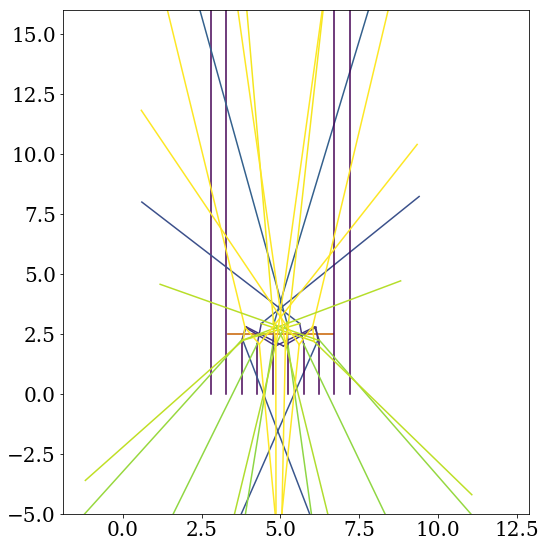

In [7]:
myRayList = RayGenerator.beam_source(2.8,0,7.2,0,10)
myLens = lens.gaussianOptics(r1=3, r2=-3,diameter=0, thickness=1,xOffSet=2,yOffSet=1,nFunction=lambda x: 2.4)
theDriver = driver(lambda x:1,myRayList.theRayList,myLens)
theDriver.rayFunc()
fig = plt.figure()
theDriver.plotter(fig)
plt.ylim(-5,16)
#plt.xlim(1,9)
plt.tight_layout()
plt.show()

/Users/pauln/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:192: RuntimeWarning: invalid value encountered in sqrt
/Users/pauln/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/pauln/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:193: RuntimeWarning: invalid value encountered in sqrt
/Users/pauln/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in arcsin
/Users/pauln/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


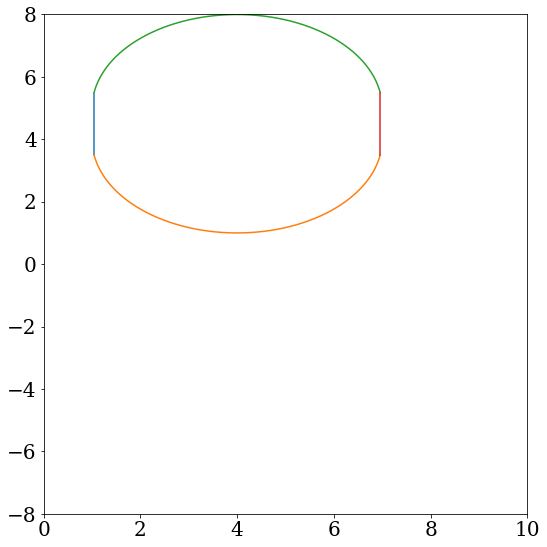

In [8]:
#tester cell
#myRayList = RayGenerator(2,-1,30,"point_source",startAngle=60*pi/180,stopAngle=120*pi/180)
#myRayList = RayGenerator(5,-1,30,"point_source", startAngle=60*pi/180,stopAngle=120*pi/180)
#myRayList = RayGenerator.point_source(5,6,30,60*pi/180, 120*pi/180)
#myRayList = RayGenerator.point_source(5,6, 1, 109.5*pi/180, 119.5*pi/180)
#myRayList = RayGenerator.converging_source(3,0,7,0,300, 65*pi/180, 115*pi/180)
#myRayList = RayGenerator.beam_source(3.485, 0, 3.49, 0, 1)
#Ray.rayCount = 0
myRayList = RayGenerator.beam_source(2.5,0,7.5,0,10)
#myRayList = RayGenerator.beam_source(3.675,0,3.678,0, 1)
#myRayList = RayGenerator.beam_source(2,0,8,0,100)
#myLens = lens.predefined("biconcave", nFunction=lambda x : 1.6, xOffSet=0,yOffSet=0)
myLens = lens.gaussianOptics(r1=3, r2=-3,diameter=0, thickness=7,xOffSet=1,yOffSet=0,nFunction=lambda x: 2.4)
#print(myLens.surfaceList)
#myLens = lens.gaussianOptics(r1=0, r2=0, diameter = 2, thickness = 2, xOffSet = 3, yOffSet = 0, nFunction=lambda x:1.5)
theDriver = driver(lambda x:1,myRayList.theRayList,myLens)
theDriver.rayFunc()
#for ray in theDriver.listOfRays:
#    print(ray.locationHistory)
fig = plt.figure()
theDriver.plotterJustLens(fig)
plt.ylim(-8,8)
plt.xlim(0,10)
#plt.axis('equal')
#plt.legend()
plt.tight_layout()
plt.show()
#add refinement for close to theta critical


In [9]:
for ray in myRayList.theRayList:
    if(ray.identity == 1):
        print(ray.locationHistory)
    #print(ray.locationHistory)
    #print(ray.angleHistory)
    #print(ray.unitVectorHistory)

In [10]:
#print(ray.unitVectorHistory)

In [11]:
a = set()

In [12]:
a = [1,2,3]
b = [4,5,6]
a+=b
print(a)

[1, 2, 3, 4, 5, 6]


In [13]:
#for i in b:
#    print(i.angleHistory)

In [14]:
myList = [1,2,3]

In [15]:
g,h,j = myList

In [16]:
print(g)

1


In [17]:
f = lambda x : np.sin(x) - x-1
b = opt.root(f, 1)
b.fun[0]

-1.1102230246251565e-14

In [18]:
a = [[1,2],[3,4,5]]
b,c = a

In [19]:
print(b,c)

[1, 2] [3, 4, 5]


In [20]:
a = [1,2,3]
const(a[:2])

NameError: name 'const' is not defined

In [ ]:
const = lambda x : 1.5
g = np.arange(25).reshape(5,5)
const1 = np.vectorize(const)
const1(g)

In [ ]:
hg = [1,2, sorted([6,7,2])]
print(hg)